In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🟡 **install dependencies**


In [1]:
!pip install torchmetrics

# 🔵 **Imports**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pack_padded_sequence

import torchvision
from torchvision import transforms as T
from torchvision.utils import make_grid
from torchvision import models

from PIL import Image

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

from collections import Counter
import os

from IPython import display

In [3]:
!python --version

Python 3.10.12


In [4]:
for lib in [np, torch, torchvision, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
torch --> 2.1.0+cu118
torchvision --> 0.16.0+cu118
tqdm --> 4.66.1


# 🔵 **Utils**

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [7]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

# 🔵 **Dataset**

## 🔵 **Load Dataset**

In [8]:
#!unzip /content/drive/MyDrive/uw-madison-gi-tract-image-segmentation.zip  -d /content/

In [9]:
t = pd.read_csv('train.csv')

In [10]:
w, h = 310, 360

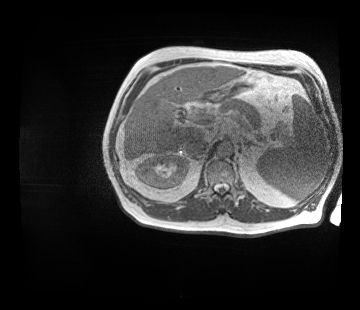

In [11]:
image = Image.open('/content/train/case78/case78_day26/scans/slice_0097_360_310_1.50_1.50.png').convert('RGB')
image

In [12]:
t

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN
115484,case30_day0_slice_0143,stomach,NaN
115485,case30_day0_slice_0144,large_bowel,NaN
115486,case30_day0_slice_0144,small_bowel,NaN


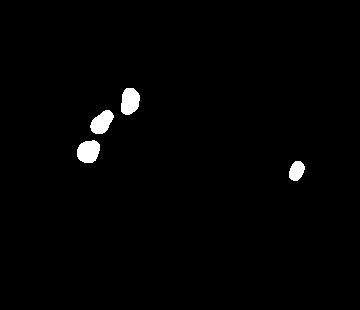

In [18]:
def rle_to_mask(rle, shape):
    mask = np.zeros(shape, dtype=np.uint8)
    rle_pairs = rle.split()
    starts = [int(x) - 1 for x in rle_pairs[0::2]]  # Subtract 1 to convert to 0-based indexing
    lengths = [int(x) for x in rle_pairs[1::2]]

    for start, length in zip(starts, lengths):
        end = start + length
        mask_flat = mask.reshape(-1)
        mask_flat[start:end] = 1

    return mask

# Example usage
rle_encoded = t['segmentation'][12000]
image_shape = (310, 360)  # Shape of the image or mask

mask = rle_to_mask(rle_encoded, image_shape)

# Save the mask as an image
mask_image = Image.fromarray(mask * 255)  # Scale the mask values from [0, 1] to [0, 255]
mask_image

In [373]:
class CleanData():
  def __init__(self, csv_address):

    self.csv_info = pd.read_csv(csv_address)

  def forward(self, text_case_address):

    csv_file = self.new_csv_info(text_case_address)
    return csv_file

  def rle_to_mask(self, rle : str, shape: tuple, seg_cls: int):
    mask = np.zeros(shape, dtype=np.uint8)
    rle_pairs = rle.split()
    starts = [int(x) - 1 for x in rle_pairs[0::2]]  # Subtract 1 to convert to 0-based indexing
    lengths = [int(x) for x in rle_pairs[1::2]]

    for start, length in zip(starts, lengths):
        end = start + length
        mask_flat = mask.reshape(-1)
        mask_flat[start:end] = seg_cls

    mask = torch.tensor(mask)
    return mask

  def new_csv_info(self, text_case_address):
    cases = np.loadtxt(text_case_address, dtype = str).tolist()
    address = []
    for case_n in cases:
      case_plus_day = os.listdir(f'/content/train/{case_n}/')
      for cpd in case_plus_day:
        im_add = os.listdir(f'/content/train/{case_n}/{cpd}/scans/')
        for im in im_add:
          address.append(f'/content/train/{case_n}/{cpd}/scans/{im}')

    new_csv = []
    c = 0
    for i, id in enumerate(self.csv_info['id']):
      id = id.split('_')
      for add in address:
        if f'{id[0]}_{id[1]}' in add and id[3] in add:
          cls = 0
          if str(self.csv_info['segmentation'][i]) == 'nan':
            cls = 0
          else:
            if self.csv_info['class'][i] == 'large_bowel':
              cls = 1
            elif self.csv_info['class'][i] == 'small_bowel':
              cls = 2
            else:
              cls = 3

          shape = (int(add.split('_')[4]), int(add.split('_')[3]))
          new_csv.append([add, self.csv_info['id'][i], cls, self.csv_info['segmentation'][i], shape])

    new_csv = pd.DataFrame(np.array(new_csv), columns = ['Image Address', 'ID', 'Class', 'Segmentation', 'Shape'])

    print('csv file created!')

    return new_csv

In [374]:
clean = CleanData('train.csv')

In [375]:
ans = input('do you have csv file for train, validation and test: (yes or no)')
if ans == 'yes':
  train_csv = pd.read_csv('train_info.csv')
  valid_csv = pd.read_csv('valid_info.csv')
  test_csv  = pd.read_csv('test_info.csv')

if ans == 'no':
  train_csv = clean.forward('train.txt')
  valid_csv = clean.forward('validation.txt')
  test_csv  = clean.forward('test.txt')

  train_csv.to_csv('train_info.csv')
  valid_csv.to_csv('valid_info.csv')
  test_csv.to_csv('test_info.csv')

do you have csv file for train, validation and test: (yes or no)yes


In [376]:
print(f'train size      : {train_csv.shape[0]}')
print(f'validation size : {valid_csv.shape[0]}')
print(f'test size       : {test_csv.shape[0]}')
print(f'total           : {train_csv.shape[0] + valid_csv.shape[0] + test_csv.shape[0]}')

train size      : 82320
validation size : 9504
test size       : 23664
total           : 115488


## 🔵 **EDA**

In [95]:
train_csv.iloc[1995:1998]

,Unnamed: 0,Image Address,ID,Class,Segmentation,Shape
1995,1995,/content/train/case129/case129_day27/scans/sli...,case129_day27_slice_0090,1,45928 8 46286 11 46644 13 47003 15 47362 16 47...,"(310, 360)"
1996,1996,/content/train/case129/case129_day27/scans/sli...,case129_day27_slice_0090,2,38324 10 38681 15 39039 19 39397 22 39728 3 39...,"(310, 360)"
1997,1997,/content/train/case129/case129_day27/scans/sli...,case129_day27_slice_0090,3,38662 2 39021 4 39380 6 39740 6 40100 6 40460 ...,"(310, 360)"


In [279]:
csv_to_show = train_csv.dropna().reset_index().drop(['index', 'Unnamed: 0'], axis = 1)

In [285]:
csv_to_show

,Image Address,ID,Class,Segmentation,Shape
0,/content/train/case129/case129_day20/scans/sli...,case129_day20_slice_0047,1,54203 2 54559 8 54918 10 55277 12 55636 13 559...,"(310, 360)"
1,/content/train/case129/case129_day20/scans/sli...,case129_day20_slice_0047,3,60663 4 61021 8 61379 11 61737 14 62095 16 624...,"(310, 360)"
2,/content/train/case129/case129_day20/scans/sli...,case129_day20_slice_0048,1,52760 4 53118 8 53477 10 53836 13 54196 14 545...,"(310, 360)"
3,/content/train/case129/case129_day20/scans/sli...,case129_day20_slice_0048,3,59224 7 59581 11 59939 14 60298 16 60656 19 61...,"(310, 360)"
4,/content/train/case129/case129_day20/scans/sli...,case129_day20_slice_0049,1,52039 5 52397 9 52756 12 53115 14 53474 16 538...,"(310, 360)"
...,...,...,...,...,...
24519,/content/train/case30/case30_day0/scans/slice_...,case30_day0_slice_0135,2,22540 1 22804 5 23069 7 23334 10 23600 11 2386...,"(266, 266)"
24520,/content/train/case30/case30_day0/scans/slice_...,case30_day0_slice_0136,1,18746 7 19009 23 19038 7 19273 44 19537 49 198...,"(266, 266)"
24521,/content/train/case30/case30_day0/scans/slice_...,case30_day0_slice_0136,2,23079 1 23343 6 23608 9 23874 11 24139 13 2440...,"(266, 266)"
24522,/content/train/case30/case30_day0/scans/slice_...,case30_day0_slice_0137,1,18746 2 19010 8 19040 3 19274 25 19302 12 1953...,"(266, 266)"


In [346]:
import random
def show_maksed_image(N, csv_file):
  images = []
  colors = [[5, 10, 0.0], [0, 1, 0], [0, 5, 2]]
  numbers = random.sample(range(1, csv_file.shape[0]), N)
  labels = ['large bowel', 'small bowel', 'stomach']
  titles = []
  for n in numbers:
    rle = csv_to_show['Segmentation'][n]
    shape = csv_to_show['Shape'][n]
    cls = csv_to_show['Class'][n]
    mask_tensor = clean.rle_to_mask(rle, eval(shape), int(cls))
    image = Image.open(csv_to_show['Image Address'][n]).convert('RGB')
    image_tensor = T.functional.to_tensor(image)
    if cls == 1:
      color = colors[0]
    elif cls == 2:
      color = colors[1]
    else :
      color = colors[2]


    image_tensor[0][mask_tensor == cls] = color[0]
    image_tensor[1][mask_tensor == cls] = color[1]
    image_tensor[2][mask_tensor == cls] = color[2]
    masked = T.functional.to_pil_image(image_tensor)
    images.append(masked)
    titles.append(labels[cls - 1])

  #show all masked images
  if len(images) < 10:
    k, j = 10, 10
  else:
    k, j = len(images), len(images)

  plt.figure(figsize = (k, j))
  if len(images)/2 != int(len(images)/2):
    k, j = len(images), 1
  else:
    k, j = int(len(images)/2), 4
  for i, image in enumerate(images):
    plt.subplot(k, j, i + 1)
    plt.imshow(image)
    plt.title(titles[i])
    plt.axis('off')
    plt.show

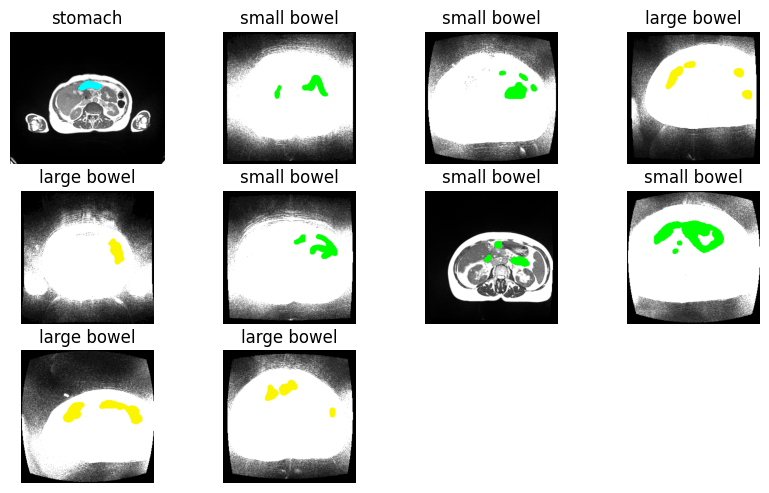

In [349]:
show_maksed_image(10, csv_to_show)

In [351]:
csv_to_show.describe()

,Class
count,24524.000000
mean,1.838852
std,0.800062
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,3.000000


large bowel:10143
small bowel:8190
stomach    :6191


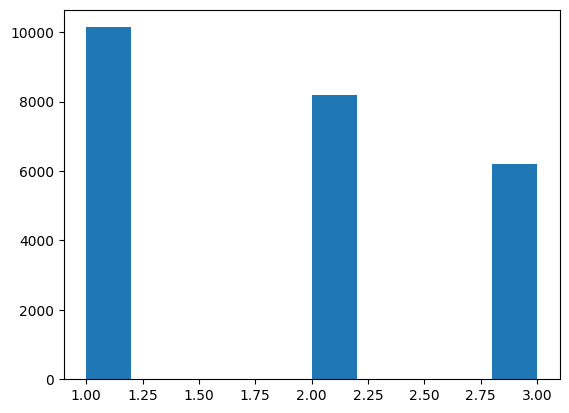

In [368]:
plt.hist(csv_to_show['Class'])
plt.show
print(f"large bowel:{csv_to_show['Class'][csv_to_show['Class'] == 1].count()}")
print(f"small bowel:{csv_to_show['Class'][csv_to_show['Class'] == 2].count()}")
print(f"stomach    :{csv_to_show['Class'][csv_to_show['Class'] == 3].count()}")

(310, 360):7637
(266, 266):15676
(234, 234):117
(276, 276):1094


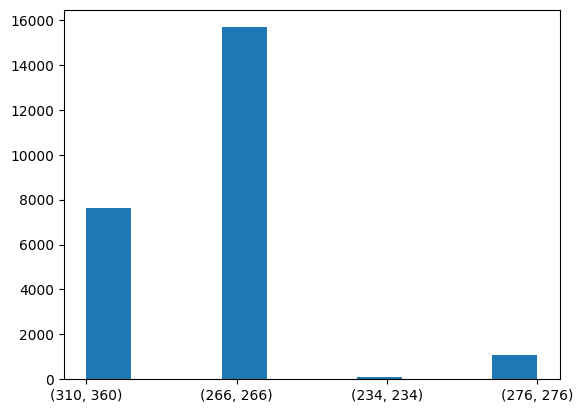

In [366]:
plt.hist(csv_to_show['Shape'])
plt.show
print(f"(310, 360):{csv_to_show['Shape'][csv_to_show['Shape'] == '(310, 360)'].count()}")
print(f"(266, 266):{csv_to_show['Shape'][csv_to_show['Shape'] == '(266, 266)'].count()}")
print(f"(234, 234):{csv_to_show['Shape'][csv_to_show['Shape'] == '(234, 234)'].count()}")
print(f"(276, 276):{csv_to_show['Shape'][csv_to_show['Shape'] == '(276, 276)'].count()}")

## 🔵 **Custom Dataset**

In [393]:
class UWMadison(Dataset):

  def __init__(self, csv_file_address, transform):
    super(UWMadison, self).__init__()

    self.data      = pd.read_csv(csv_file_address).dropna().reset_index()
    self.transform = transform

  def __getitem__(self, index):
    image_path  = self.data['Image Address'][index]
    rle_segment = self.data['Segmentation'][index]
    shape       = eval(self.data['Shape'][index])
    cls         = self.data['Class'][index] - 1
    print()

    pil_image  = Image.open(image_path).convert('RGB')
    if self.transform:
      image_tensor = self.transform(pil_image)
    else:
      image_tensor = T.functional.to_tensor(pil_image)

    mask        = clean.rle_to_mask(rle_segment, shape, cls)

    return image_tensor, mask

  def __len__(self):

    return self.data.shape[0]

In [394]:
train_dataset = UWMadison('train_info.csv', None)
valid_dataset = UWMadison('valid_info.csv', None)
test_dataset  = UWMadison('test_info.csv', None)

In [395]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(24524, 3069, 6320)

In [396]:
image_tensor, mask = train_dataset[0]

In [397]:
image_tensor.shape, mask.shape

(torch.Size([3, 310, 360]), torch.Size([310, 360]))

## 🔵 **DataLoader**

In [398]:
train_loader = DataLoader(train_dataset, batch_size = 1, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 1, shuffle = False)
test_loader  = DataLoader(test_dataset , batch_size = 1, shuffle = False)

In [399]:
image_tensor, mask = next(iter(train_loader))
image_tensor.shape, mask.shape

(torch.Size([1, 3, 266, 266]), torch.Size([1, 266, 266]))

In [400]:
image_tensor, mask = next(iter(valid_loader))
image_tensor.shape, mask.shape

(torch.Size([1, 3, 310, 360]), torch.Size([1, 310, 360]))

In [401]:
image_tensor, mask = next(iter(valid_loader))
image_tensor.shape, mask.shape

(torch.Size([1, 3, 310, 360]), torch.Size([1, 310, 360]))